# 1. Download and Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Para el manejo de datasets y transformaciones
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split



In [ ]:
import zipfile
import os

# Ruta al archivo descargado
zip_path = "gtsrb-german-traffic-sign.zip"

# Directorio donde se extraerá el contenido
extract_path = "gtsrb_dataset"

# Extraer el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Contenido extraído a {extract_path}")


# 2. Loading Dataset (Traffic Signs Images)

In [ ]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((30, 30)),  # Ajustamos las imágenes al mismo tamaño
    transforms.ToTensor(),        # Convertimos a tensores
    transforms.Normalize(mean=[0.3403, 0.3121, 0.3214], std=[0.2724, 0.2608, 0.2669])  # Normalizamos
])

# Ruta al directorio del dataset
data_dir = 'gtsrb_dataset/Train'

# Cargamos el dataset utilizando ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


# 1. Verificar el tamaño y las dimensiones del dataset
print(f"Número total de imágenes: {len(dataset)}")

# Obtener una muestra del dataset
sample_image, sample_label = dataset[0]

# Imprimir las dimensiones de la imagen
print(f"Dimensiones de la imagen: {sample_image.shape}")  # Debería ser [3, 30, 30]

# Número de clases
num_classes = len(dataset.classes)
print(f"Número de clases: {num_classes}")


Número total de imágenes: 39209
Dimensiones de la imagen: torch.Size([3, 30, 30])
Número de clases: 43


# 2.1 Aqui se puede apreciar la diferencia de las imagenes al estar normalizada y sin normalizar 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79279155..2.5131392].


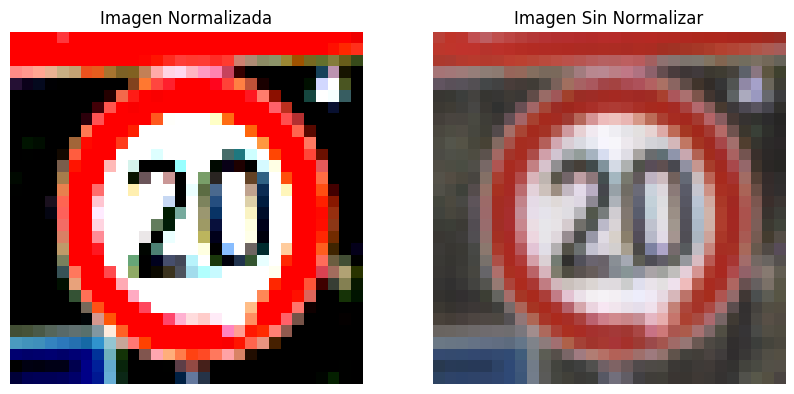

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Función para deshacer la normalización
def unnormalize(img, mean, std):
    """Invierte la normalización de una imagen tensorial."""
    img = img.clone()  # Crea una copia de la imagen
    for i in range(img.shape[0]):  # Por cada canal
        img[i] = img[i] * std[i] + mean[i]
    return img

# Supongamos que esta es la transformación usada en el dataset
mean = [0.3403, 0.3121, 0.3214]  # Valores medios calculados o usados
std = [0.2724, 0.2608, 0.2669]   # Desviaciones estándar usadas

# Selecciona la imagen del dataset
img_tensor = dataset[20][0]  # Obtiene el tensor de la imagen (canales, alto, ancho)

# Imagen normalizada (tal como está en el dataset)
img_normalized = img_tensor.numpy()
img_normalized = np.transpose(img_normalized, (1, 2, 0))  # Reordena para formato (alto, ancho, canales)

# Imagen sin normalizar
img_unnormalized = unnormalize(img_tensor, mean, std).numpy()
img_unnormalized = np.transpose(img_unnormalized, (1, 2, 0))  # Reordena para formato (alto, ancho, canales)

# Mostrar ambas imágenes
plt.figure(figsize=(10, 5))

# Imagen normalizada
plt.subplot(1, 2, 1)
plt.imshow(img_normalized)
plt.title("Imagen Normalizada")
plt.axis("off")

# Imagen sin normalizar
plt.subplot(1, 2, 2)
plt.imshow(img_unnormalized)
plt.title("Imagen Sin Normalizar")
plt.axis("off")

plt.show()


# 2.2 Aqui se separan los datos en los datasets de entrenamiento y prueba ademas de acortar el maximo de datos por categoria para que no exista tanto desequilibrio de datos 

In [5]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

targets = np.array(dataset.targets)
num_classes = 43 # Número de clases 

# Número de ejemplos que se quiere por clase (puedes ajustarlo)
samples_per_class = 700

# Proporción del conjunto de validación (por ejemplo, 20% de los datos)
validation_split = 0.3

# Crear listas para los índices de entrenamiento y validación
train_indices = []
val_indices = []

# Iterar sobre cada clase y dividir los índices en entrenamiento y validación
for class_idx in range(num_classes):
    # Obtener los índices de todos los ejemplos de la clase actual
    class_indices = np.where(targets == class_idx)[0]

    # Limitar el número de ejemplos a `samples_per_class` si hay más ejemplos
    if len(class_indices) > samples_per_class:
        class_indices = np.random.choice(class_indices, samples_per_class, replace=False)

    # Dividir los índices de la clase en entrenamiento y validación
    train_idx, val_idx = train_test_split(class_indices, test_size=validation_split, random_state=42)

    # Añadir los índices a las respectivas listas
    train_indices.extend(train_idx)
    val_indices.extend(val_idx)

# Crear los subconjuntos de entrenamiento y validación
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, val_indices)

print(f"Número total de imágenes train loader: {len(train_subset)}")
print(f"Número total de imágenes test loader: {len(test_subset)}")

Número total de imágenes train loader: 15567
Número total de imágenes test loader: 6672


# 2.3 imprimimos un grafico para visualizar los datos por categoria que se guardaron  

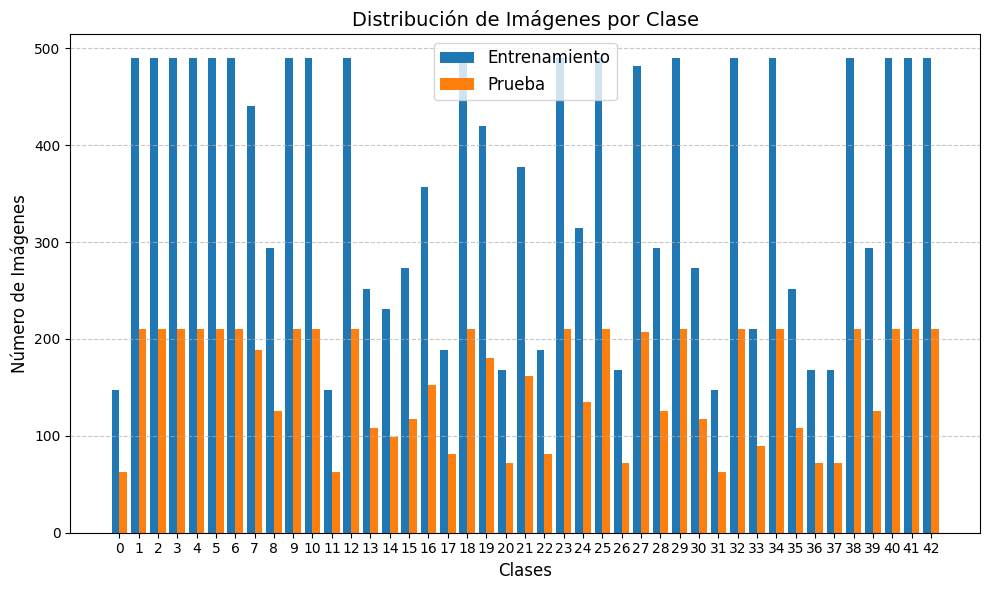

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Obtener las etiquetas de los subconjuntos
train_labels = [dataset.targets[idx] for idx in train_subset.indices]
test_labels = [dataset.targets[idx] for idx in test_subset.indices]

# Contar ejemplos por clase
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

# Ordenar las clases (en caso de que no estén en orden ascendente)
classes = sorted(train_class_counts.keys())  # Todas las clases disponibles
train_counts = [train_class_counts[cls] for cls in classes]
test_counts = [test_class_counts[cls] for cls in classes]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Barras para el conjunto de entrenamiento
plt.bar(classes, train_counts, width=0.4, label="Entrenamiento", align='center')

# Barras para el conjunto de prueba
plt.bar([x + 0.4 for x in classes], test_counts, width=0.4, label="Prueba", align='center')

# Configurar el gráfico
plt.xlabel("Clases", fontsize=12)
plt.ylabel("Número de Imágenes", fontsize=12)
plt.title("Distribución de Imágenes por Clase", fontsize=14)
plt.xticks([x + 0.2 for x in classes], classes)  # Ajusta la posición de las etiquetas de las clases
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



# 3. Data Splitting and conversion

In [7]:
# # Obtener índices para dividir el dataset
# train_size = int(0.7 * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders para cargar los datos en batches
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


# 4. Creating and Compiling the Model

In [8]:
class TrafficSignClassifier(nn.Module):
    def __init__(self):
        super(TrafficSignClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5)  # 3 canales de entrada para imágenes RGB
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Ajustar según el tamaño de las imágenes
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 43)  # 43 clases de señaléticas

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Tamaño de salida: (batch_size, 32, 26, 26)
        x = F.relu(self.conv2(x))  # Tamaño de salida: (batch_size, 32, 22, 22)
        x = self.pool(x)           # Tamaño de salida: (batch_size, 32, 11, 11)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))  # Tamaño de salida: (batch_size, 64, 9, 9)
        x = F.relu(self.conv4(x))  # Tamaño de salida: (batch_size, 64, 6, 6)
        x = self.pool(x)           # Tamaño de salida: (batch_size, 64, 3, 3)
        x = self.dropout2(x)
        x = x.view(-1, 128 * 4 * 4)  # Aplanamiento si cambio fc1 debo de cambiar el valor aqui tambien solo el de entrada salida de conv4
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

model = TrafficSignClassifier()

In [9]:


# Utilizar GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 5. Training the Model

In [ ]:
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100.0 * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validación
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(test_loader.dataset)
    val_accuracy = 100.0 * val_correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 1.7147, Train Acc: 50.50%, Val Loss: 0.3499, Val Acc: 90.86%
Epoch 2/10, Train Loss: 0.3901, Train Acc: 87.82%, Val Loss: 0.1229, Val Acc: 97.03%
Epoch 3/10, Train Loss: 0.2180, Train Acc: 93.59%, Val Loss: 0.0697, Val Acc: 98.28%
Epoch 4/10, Train Loss: 0.1590, Train Acc: 95.34%, Val Loss: 0.0510, Val Acc: 98.91%


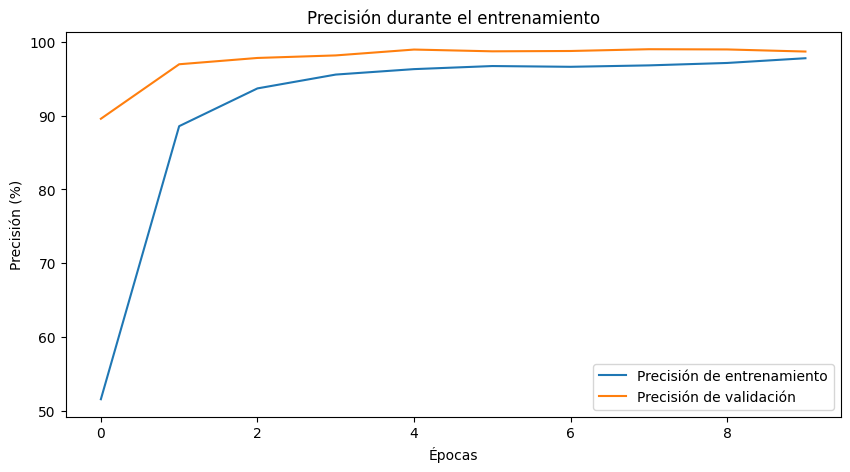

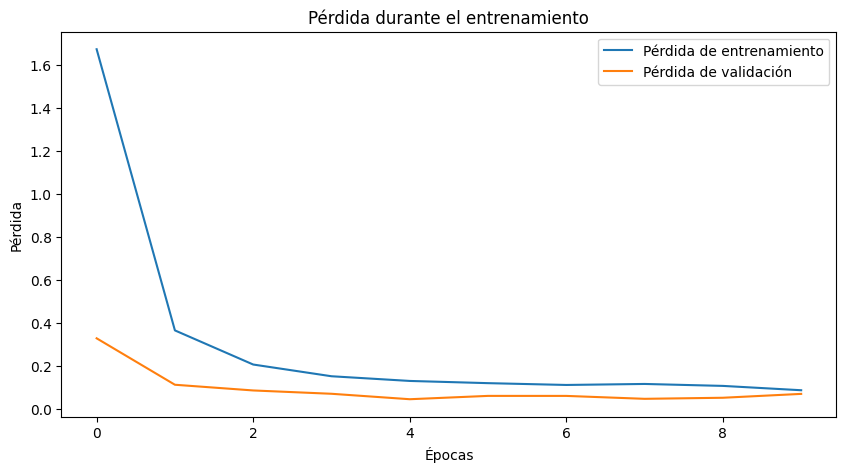

In [ ]:
# Gráfica de la precisión
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Precisión de entrenamiento')
plt.plot(val_accuracies, label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.legend()
plt.show()

# Gráfica de la pérdida
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# 6. Visualizing the performance of the Model during Training Phase

# 7. Loading Test Dataset and Evaluating the Model

Precisión de la clase 0 (0): 100.00% (63/63)
Precisión de la clase 1 (1): 95.71% (201/210)
Precisión de la clase 2 (10): 100.00% (210/210)
Precisión de la clase 3 (11): 96.67% (203/210)
Precisión de la clase 4 (12): 99.52% (209/210)
Precisión de la clase 5 (13): 98.57% (207/210)
Precisión de la clase 6 (14): 99.52% (209/210)
Precisión de la clase 7 (15): 98.94% (187/189)
Precisión de la clase 8 (16): 99.21% (125/126)
Precisión de la clase 9 (17): 100.00% (210/210)
Precisión de la clase 10 (18): 97.14% (204/210)
Precisión de la clase 11 (19): 100.00% (63/63)
Precisión de la clase 12 (2): 99.05% (208/210)
Precisión de la clase 13 (20): 97.22% (105/108)
Precisión de la clase 14 (21): 100.00% (99/99)
Precisión de la clase 15 (22): 100.00% (117/117)
Precisión de la clase 16 (23): 100.00% (153/153)
Precisión de la clase 17 (24): 100.00% (81/81)
Precisión de la clase 18 (25): 99.05% (208/210)
Precisión de la clase 19 (26): 98.89% (178/180)
Precisión de la clase 20 (27): 100.00% (72/72)
Precis

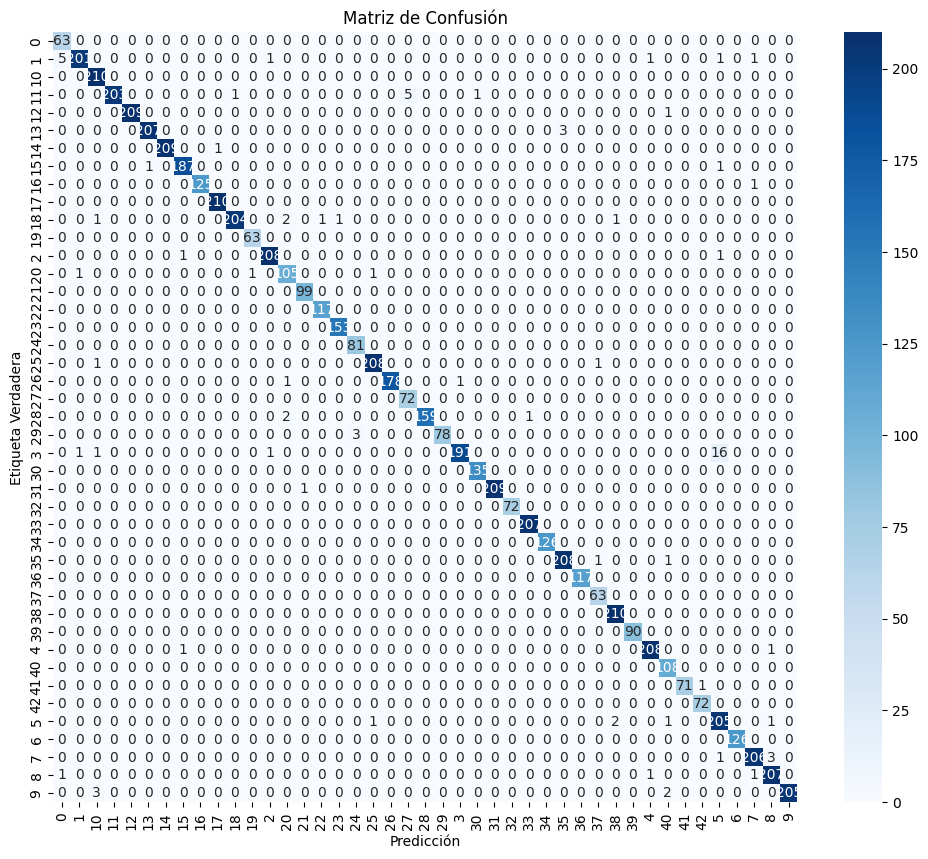

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        63
           1       0.99      0.96      0.97       210
          10       0.97      1.00      0.99       210
          11       1.00      0.97      0.98       210
          12       1.00      1.00      1.00       210
          13       1.00      0.99      0.99       210
          14       1.00      1.00      1.00       210
          15       0.99      0.99      0.99       189
          16       1.00      0.99      1.00       126
          17       1.00      1.00      1.00       210
          18       1.00      0.97      0.98       210
          19       0.98      1.00      0.99        63
           2       0.99      0.99      0.99       210
          20       0.95      0.97      0.96       108
          21       0.99      1.00      0.99        99
          22       0.99      1.00      1.00       117
          23       0.99      1.00      1.00       153
          24       0.96    

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializar contadores y listas
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
all_preds = []
all_labels = []
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            if c[i].item() == 0:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(labels[i].cpu().item())
                misclassified_preds.append(predicted[i].cpu().item())

# Calcular y mostrar la precisión por clase
for i in range(num_classes):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Precisión de la clase {i} ({dataset.classes[i]}): {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'No hay muestras para la clase {i} ({dataset.classes[i]})')

# Generar y mostrar la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Generar y mostrar el reporte de clasificación
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print(report)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17706937..1.8188267].


Imágenes clasificadas correctamente:


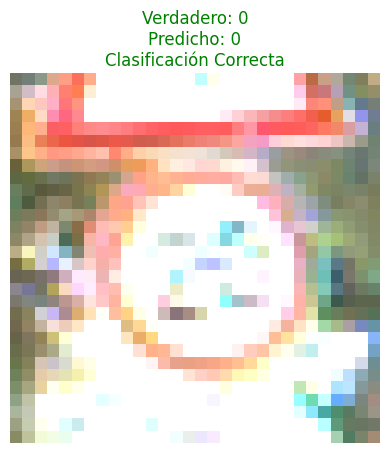

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.30725795..1.4729829].


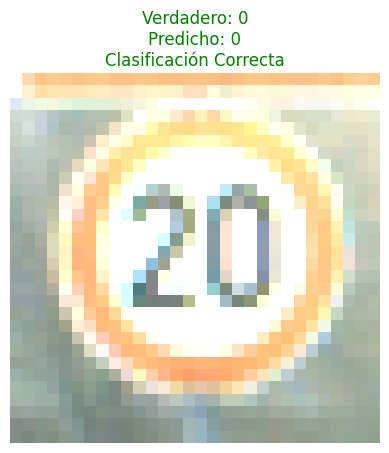

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06251979..1.8188267].


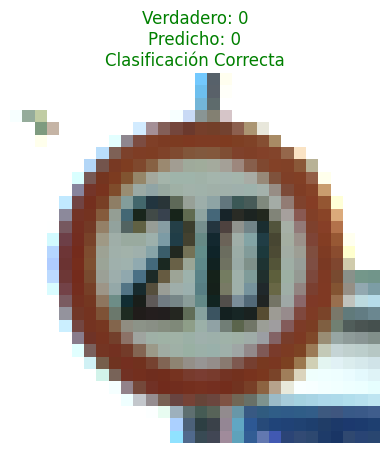

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09851068..1.4157777].


Imágenes mal clasificadas:


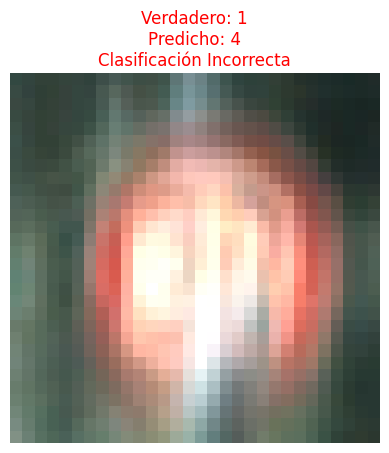

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18488887..1.7712626].


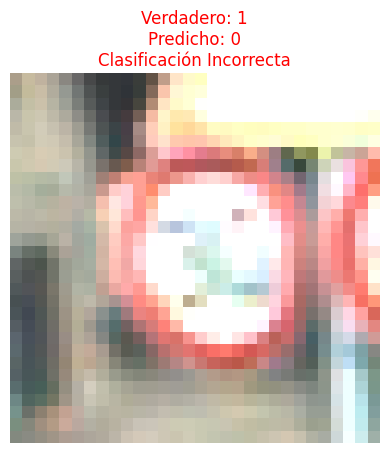

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021286488..1.8188267].


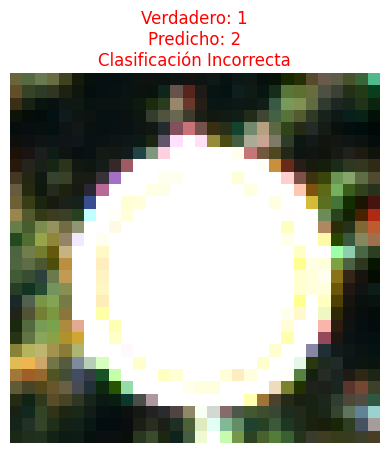

In [ ]:
import random


# Inicializar listas para imágenes clasificadas correctamente e incorrectamente
correctly_classified_images = []
correctly_classified_labels = []
correctly_classified_preds = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                correctly_classified_images.append(images[i].cpu())
                correctly_classified_labels.append(labels[i].cpu().item())
                correctly_classified_preds.append(preds[i].cpu().item())
            else:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(labels[i].cpu().item())
                misclassified_preds.append(preds[i].cpu().item())

# Definir función para mostrar imágenes
def imshow(img, true_label, predicted_label, correct):
    img = img.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # Desnormalizar
    plt.imshow(img)
    title = f'Verdadero: {dataset.classes[true_label]}\nPredicho: {dataset.classes[predicted_label]}'
    if correct:
        plt.title(title + '\nClasificación Correcta', color='green')
    else:
        plt.title(title + '\nClasificación Incorrecta', color='red')
    plt.axis('off')
    plt.show()

# Mostrar algunas imágenes clasificadas correctamente
print("Imágenes clasificadas correctamente:")
for i in range(min(3, len(correctly_classified_images))):
    imshow(correctly_classified_images[i], correctly_classified_labels[i], correctly_classified_preds[i], correct=True)

# Mostrar algunas imágenes mal clasificadas
print("Imágenes mal clasificadas:")
for i in range(min(3, len(misclassified_images))):
    imshow(misclassified_images[i], misclassified_labels[i], misclassified_preds[i], correct=False)
